<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Para incrementar na melhora da eficiência da entrega a Loggi Bud precisa dos dados da quantidade de entrega uma média de entregas realizadas e uma visão melhor do fluxo das entregas, para isso foi realizada algumas etapas.

# 2. Pacotes e bibliotecas

## 2.1. Preparando ambiente

*Imports* - Nativo do python

In [ ]:
import json
import os
import requests
import matplotlib.pyplot as plt

*Imports* - De terceiros

In [ ]:
import geopandas
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
import pandas as pd


Baixando Mapa

In [ ]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx


# 3 Extração de dados

In [ ]:
#Download da instancia do DF em formato json
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

#Download da instância do Pará em formato json
#!wget -q "https://raw.githubusercontent.com/noragan03/Projeto-Loggi-Bud/main/dataset/deliveries.json" -O deliveries.json

In [ ]:
#abrindo o arquivo de dados brutos

with open('deliveries.json', mode='r',encoding='utf8') as file:
  data = json.load(file)

deliveries_df = pd.DataFrame(data)

#Separar a linha única em diferentes colunas
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

#definindo as informações importantes da coluna origin
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

#Joga fora a coluna origin
deliveries_df = deliveries_df.drop("origin", axis=1)

#Seleciona as colunas importantes da variável deliveries_df
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]

#Renomeia as colunas
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)


#Separa a linha única em várias outras linhas seguindo o index
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)


deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)



#4. Agregando informações
*Geocodificação* - base

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)

geolocator = Nominatim(user_agent="noragan_geocoder")

geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

*O código*

In [ ]:
#Montar o formato para pegar as coordenadas do endereco
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

#Normalizar os dados que recebeu no código acima e quebrar em colunas
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46082661,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,46676578,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43508444,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


*Limpeza dos dados*

In [ ]:
#Pega os dados desejados, renomeia elas e pega os dados específicos e
#Caso se encontre vazio, pega outros dados
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

#Concatenar as informações recebidas no hub_df
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]

#Organizando e ordenando as colunas sem perder os dados
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]


In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [ ]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)


In [ ]:
deliveries_df.head(5)

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


## 5\. Visualização

### Quantidade de entregas por subúrbio

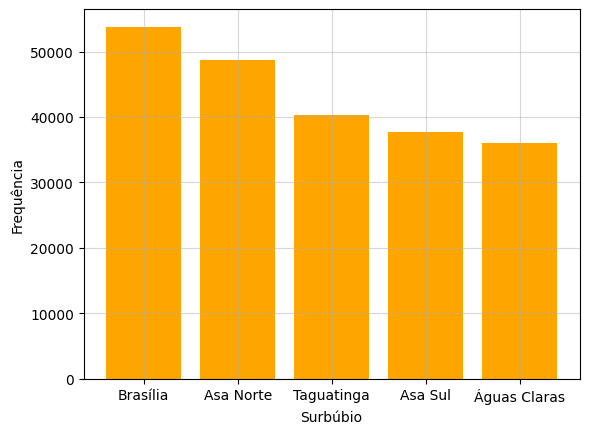

In [ ]:
import matplotlib.pyplot as plt

#Grade
plt.grid(which='both', alpha=0.5)

#Contagem das aparições de suburb
frequencia = deliveries_df["delivery_suburb"].value_counts()

#Seleciona apenas os 5 primeiros
frequencia = frequencia.nlargest(5)

#gráfico de barras
plt.bar(frequencia.index, frequencia.values, color='orange')
plt.xlabel('Surbúbio')
plt.ylabel('Frequência')

plt.show()

Pode se considerar que do Distrito Federal, **Brasília** tem um número de entregas mais frequentes passando de 50 mil e **Asa Norte** sendo ela a segunda maior com entregas um pouco abaixo de 50 mil sendo seguido de **Taguatinga** que chega a 40 mil entregas

### Média do tamanho da entrega e seu mínimo de entregas (delivery_size)

In [ ]:
deliveries_df['delivery_size'].describe()

count    636149.000000
mean          5.512111
std           2.874557
min           1.000000
25%           3.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: delivery_size, dtype: float64

Em relação ao tamanho da entrega, o tamanho médio para entrega para o Distrito Federal tem sido de 5 itens, portanto ao menos 5 itens tem sido entregues, onde o mínimo de entregas é 1

### Criando um mapa

In [ ]:
mapa = geopandas.read_file('distrito-federal.shp')
mapa = mapa.loc[[0]] #[DF, Estado de Goiás]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [ ]:
#Recriando o Hub

hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df['hub_lng'], hub_df["hub_lat"]))

#Adição do Mapa da entrega
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))


<ipython-input-24-7c85d5c9d2c2>:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


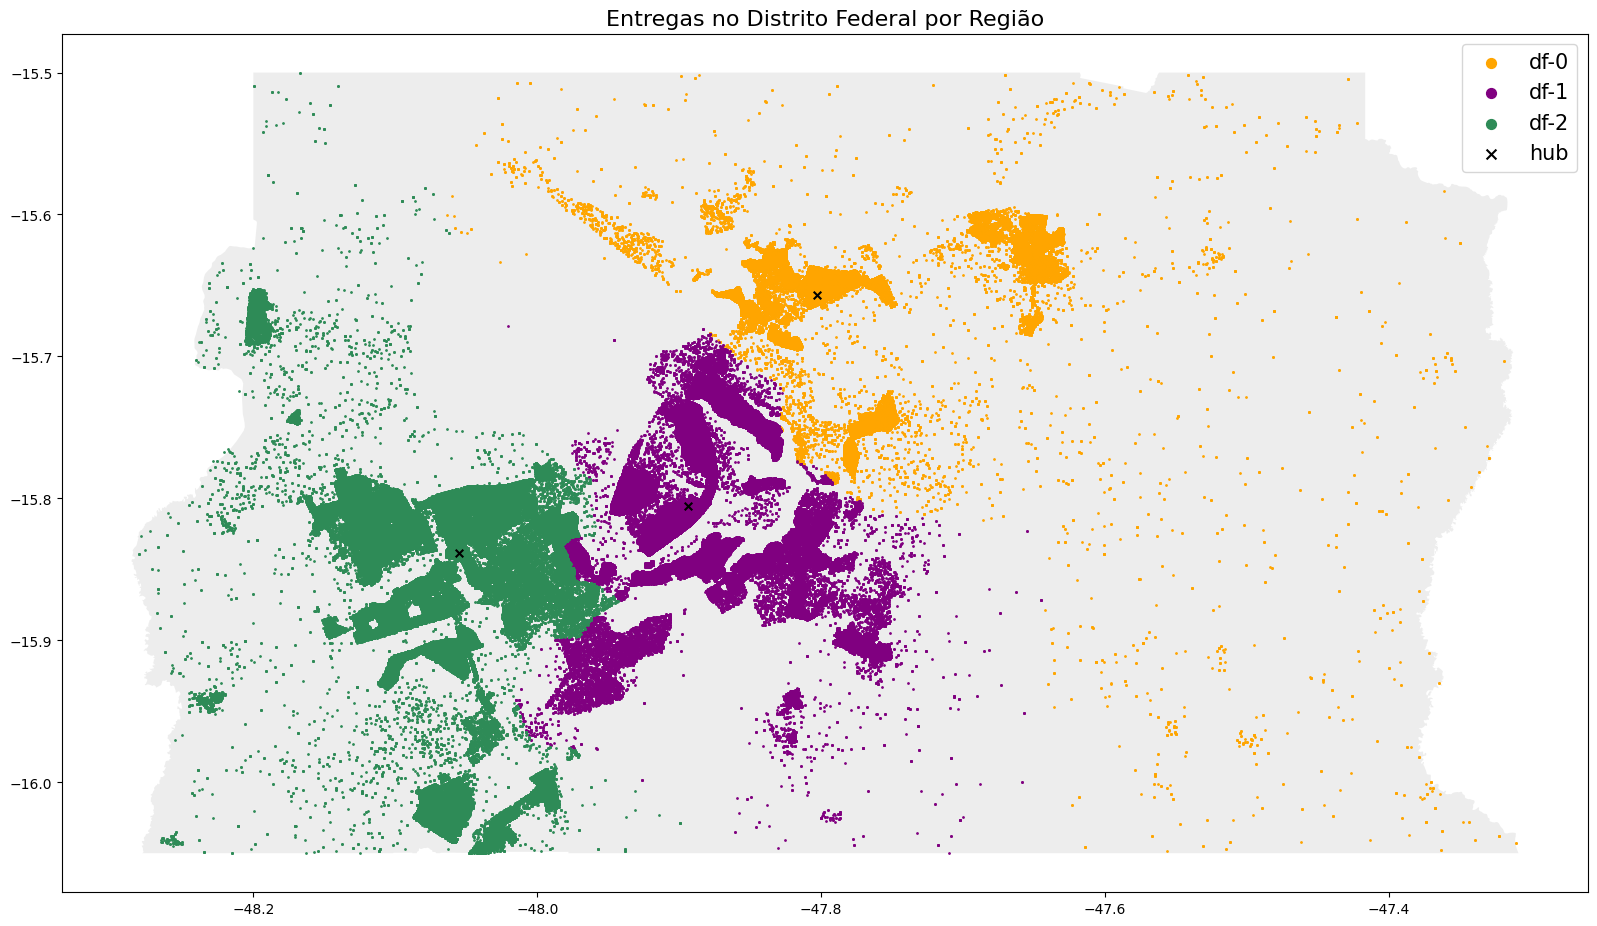

In [ ]:
import matplotlib.pyplot as plt
#Visualização do mapa
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color='lightgrey')

# plot das entregas
geo_deliveries_df.query('region == "df-0"').plot(ax=ax, markersize=1, color='orange', label='df-0')
geo_deliveries_df.query('region == "df-1"').plot(ax=ax, markersize=1, color='purple', label='df-1')
geo_deliveries_df.query('region == "df-2"').plot(ax=ax, markersize=1, color='seagreen', label='df-2')

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker='x', color='black', label='hub')

# plot da legenda
plt.title('Entregas no Distrito Federal por Região', fontdict={'fontsize': 16})
lgnd = plt.legend(prop={'size': 15}) #legenda das bolinhas
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

Visualizando o mapa podemos tirar a conclusão que a região do hub 2 possui um fluxo maior de entregas, sendo que o hub 2 e 0 descritos pelos pontos verde e laranja sequentemente, possuem entregas em locais mais distantes podendo gerar um custo e um gasto de tempo maior de entrega.

Para uma possível solução, é sugerível que avalie o tempo médio das entregas e o custo gerado, além de quantas entregas por local são realizadas por semana, desta forma poderíamos selecionar as entregas que seriam realizadas em um determinado local para serem realizadas aquelas que são próximas uma das outras primeiro.